# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

### Импорты

In [1]:
from warnings import simplefilter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

### Загрузка данных

In [2]:
df_train = pd.read_csv('gold_recovery_train_new.csv')
df_test = pd.read_csv('gold_recovery_test_new.csv')
df_full = pd.read_csv('gold_recovery_full_new.csv')

### Первичный анализ данных

#### Характеристики столбцов

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


**Выводы:** Файлы открыты штатно. Размерность пространства признаков довольно высока. Некоторые столбцы отсутствуют в тестовой выборки. Имеются пропуски, особенно много в тренировочной выборке. С типами данных проблем нет, разве что надо скастовать столбец date в тип datetime.

In [6]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%dT%H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%dT%H:%M:%S')
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%dT%H:%M:%S')

#### Первые строки

In [7]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [9]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


#### Полные дубликаты

In [10]:
df_train.duplicated().sum()

0

In [11]:
df_test.duplicated().sum()

0

In [12]:
df_test.duplicated().sum()

0

#### Пропуски

In [13]:
def pass_value_barh(df, title):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,40), legend = False, fontsize = 16)
            .set_title(title + " % пропусков" + "\n", fontsize = 22, color = 'SteelBlue')
        );    
    except:
        print('пропусков не осталось :) ')

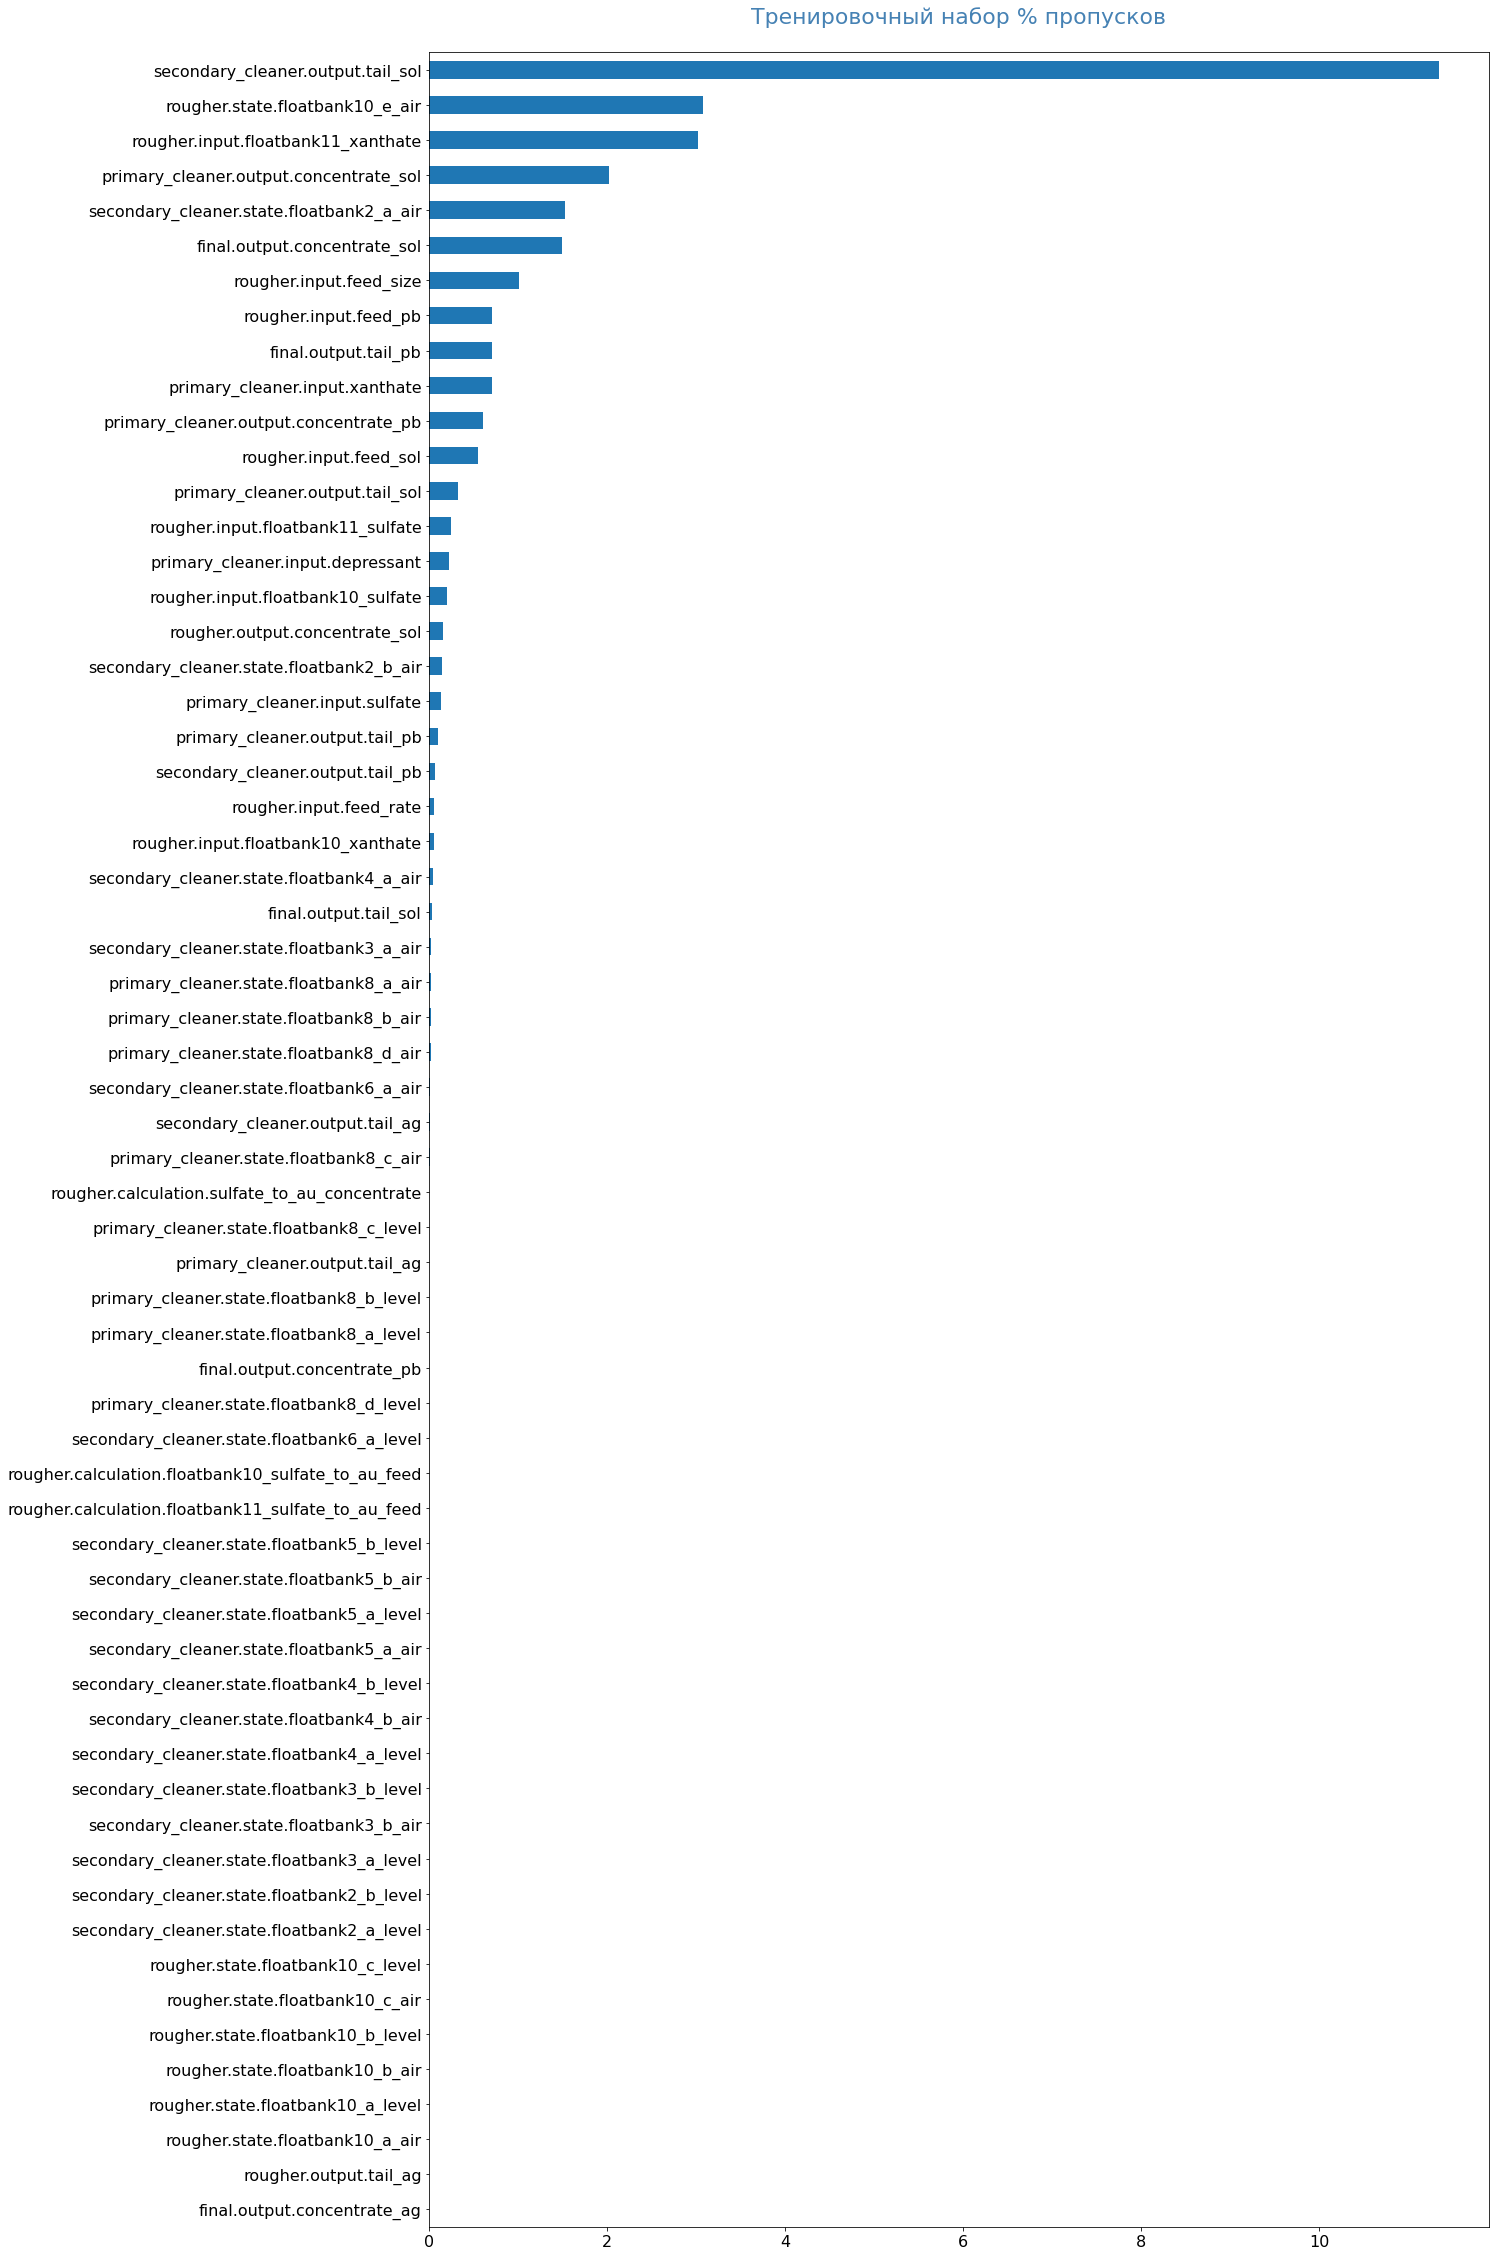

In [14]:
pass_value_barh(df_train, 'Тренировочный набор')

В некоторых столбцах действительно не мало пропусков, но насколько они критичны для обучения надо смотреть дальше потому, что не все признаки будут использоваться для обучения.

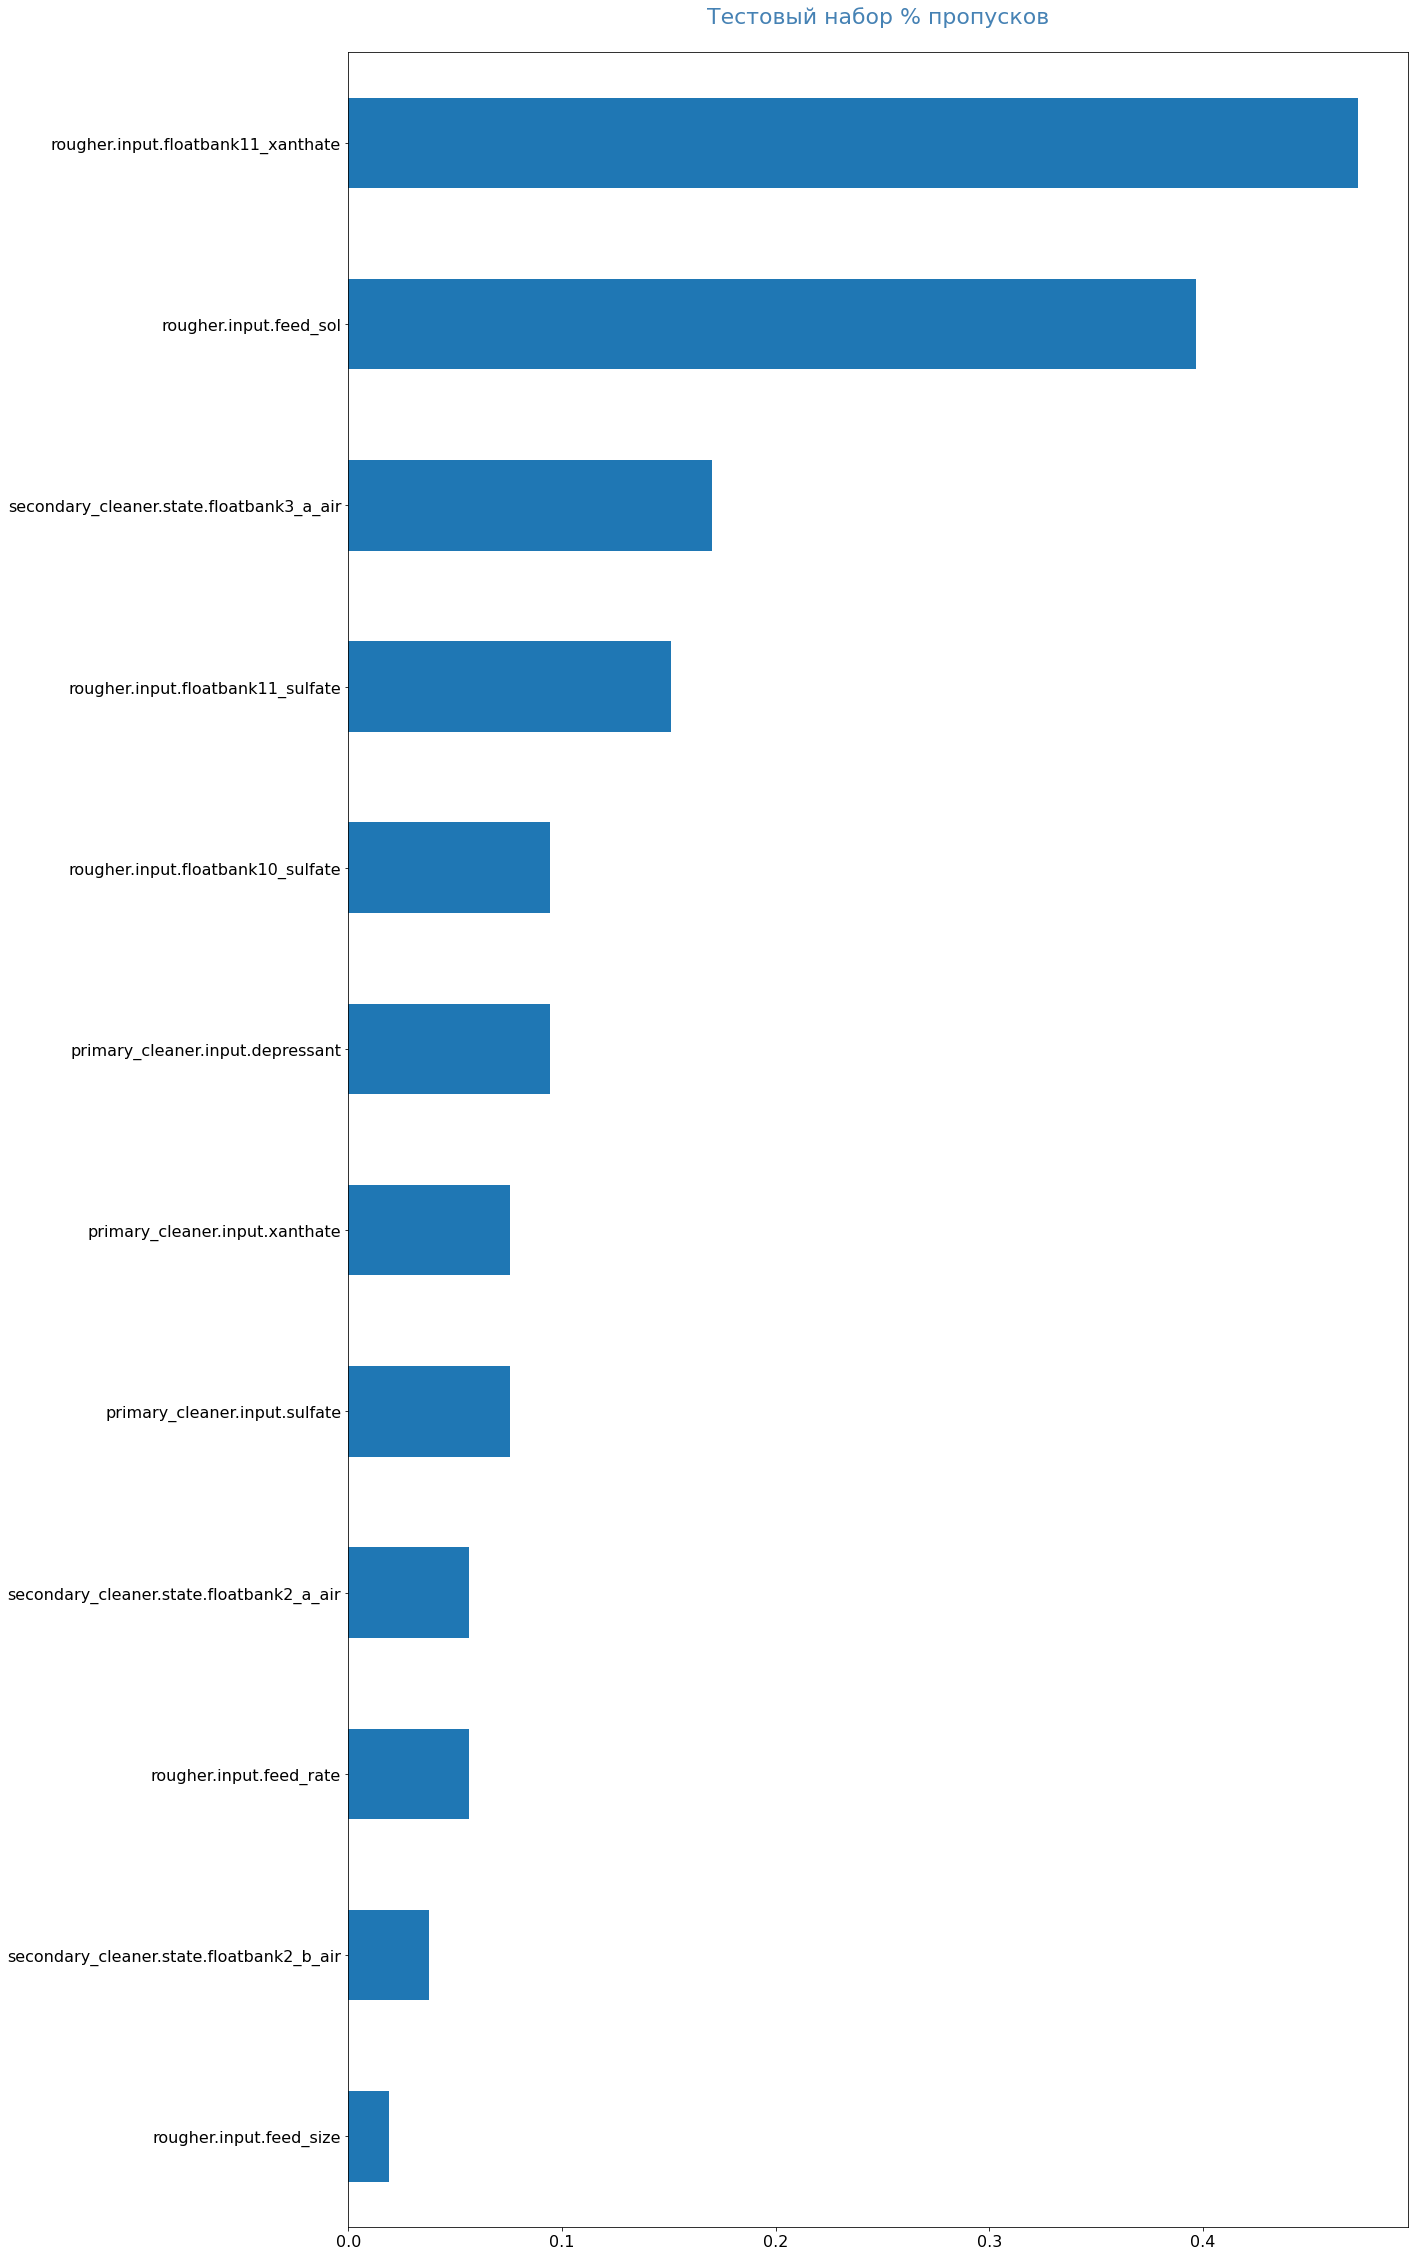

In [15]:
pass_value_barh(df_test, 'Тeстовый набор')

Пропусков значительно меньше и в процентном отношении и в количестве столбцов.

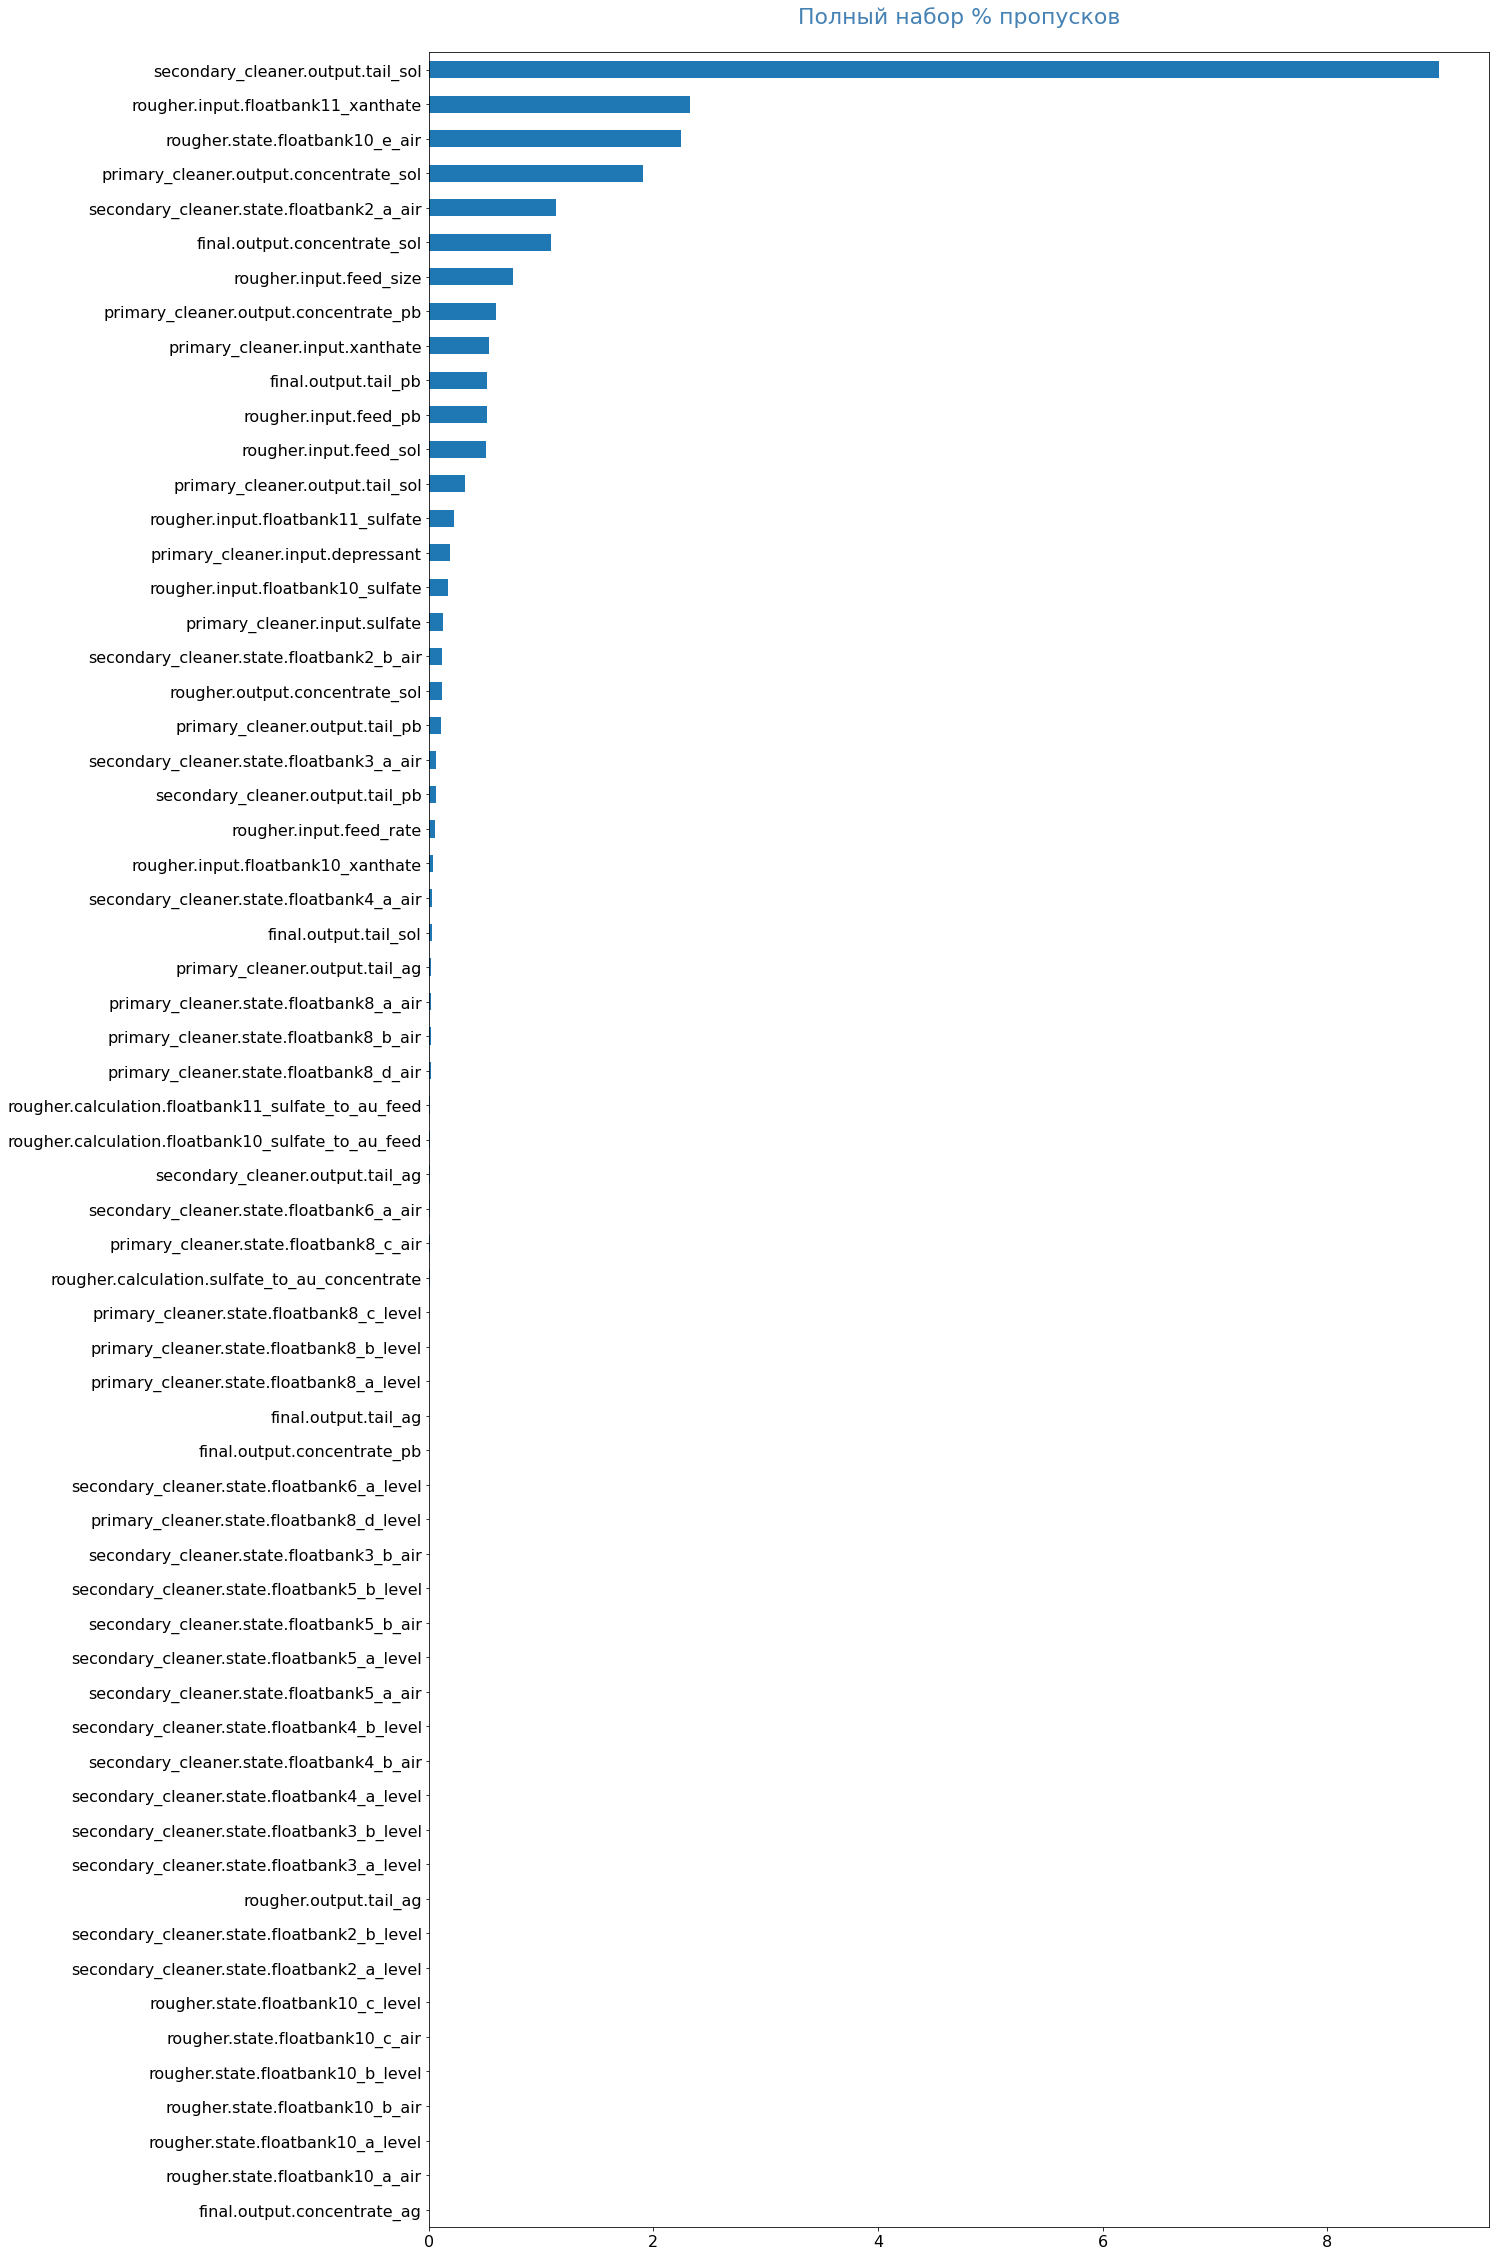

In [16]:
pass_value_barh(df_full, 'Полный набор')

Соответствует тренировочному набору.

#### Описательная статистика

In [17]:
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [18]:
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


In [19]:
df_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


**Выводы:** Категориальных переменных нет. Все переменные, кроме даты, судя по всему относятся к шкале отношений. Желательно шкалирование признаков, так как у них довольно сильно отличаются характеристики разброса. Кое где присутствую выбросы, но не критично.

#### Матрица корреляций

<ipython-input-20-10c5d35cd761>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(abs(df_train.corr()), cmap="rocket_r");


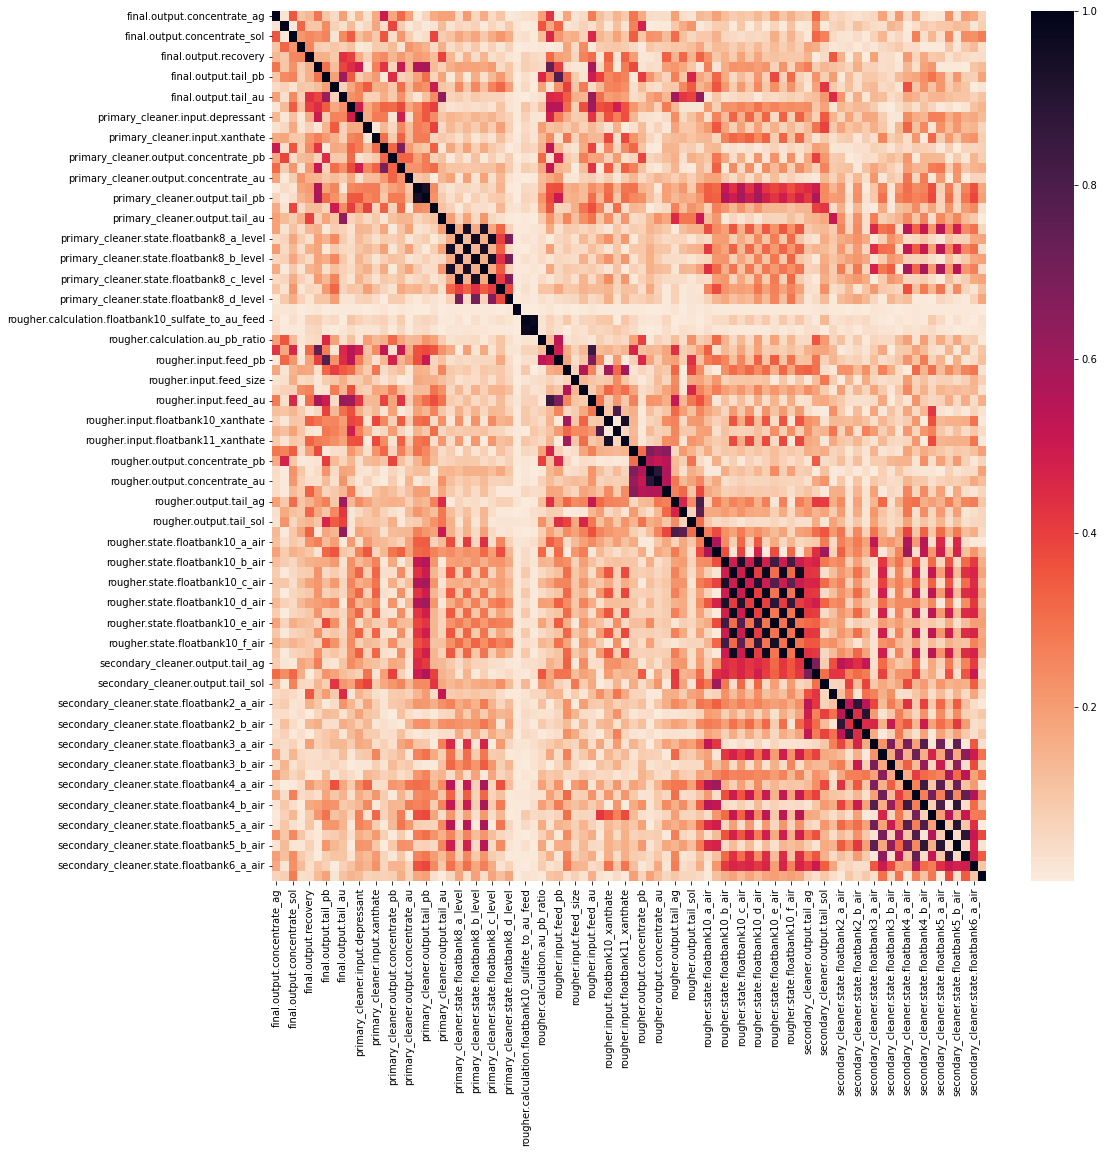

In [20]:
plt.figure(figsize = (16,16))
sns.heatmap(abs(df_train.corr()), cmap="rocket_r"); 

<ipython-input-21-b209878eb9a5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(abs(df_test.corr()), cmap="rocket_r");


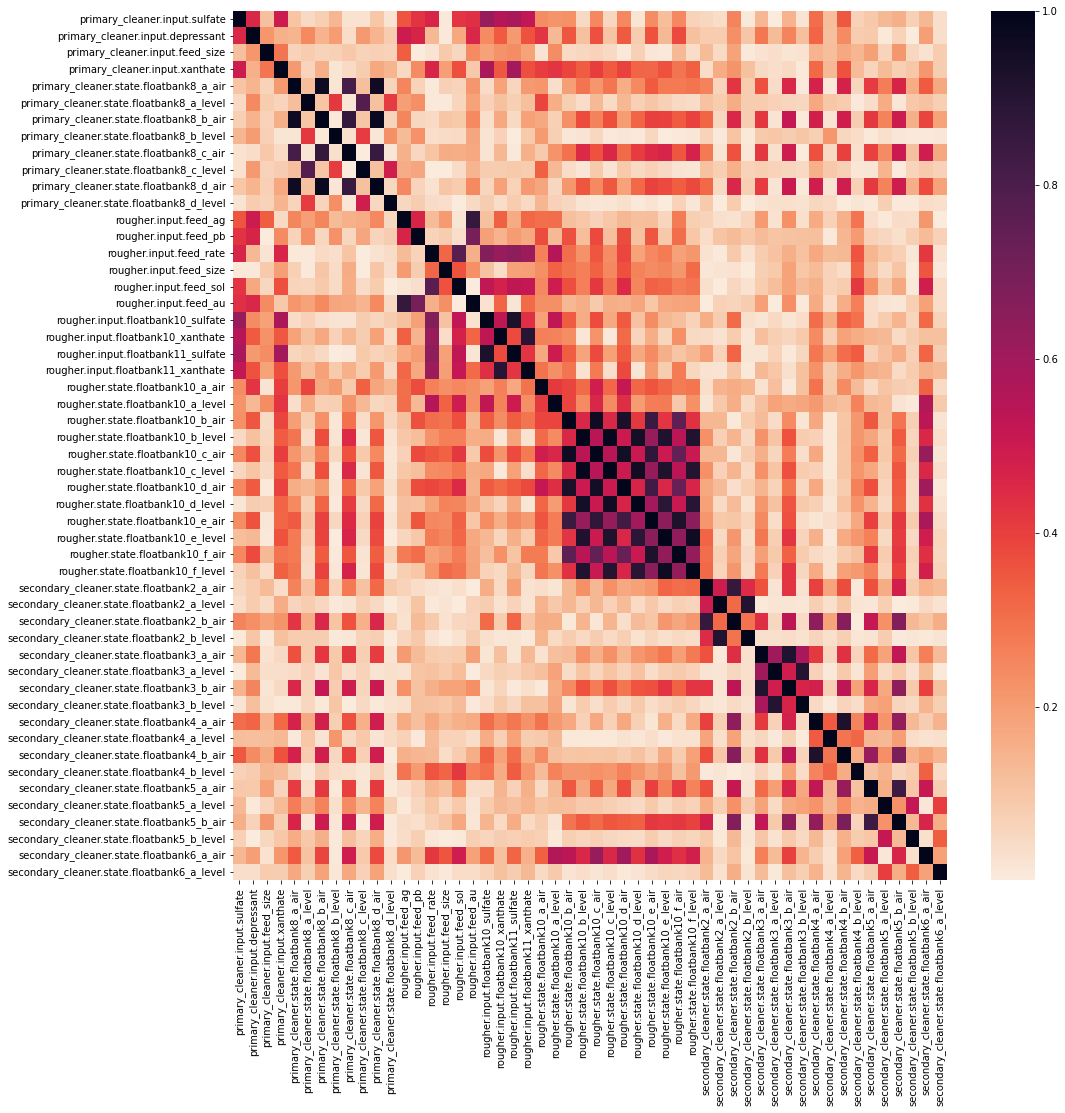

In [21]:
plt.figure(figsize = (16,16))
sns.heatmap(abs(df_test.corr()), cmap="rocket_r"); 

<ipython-input-22-1caa6801ea15>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(abs(df_full.corr()), cmap="rocket_r");


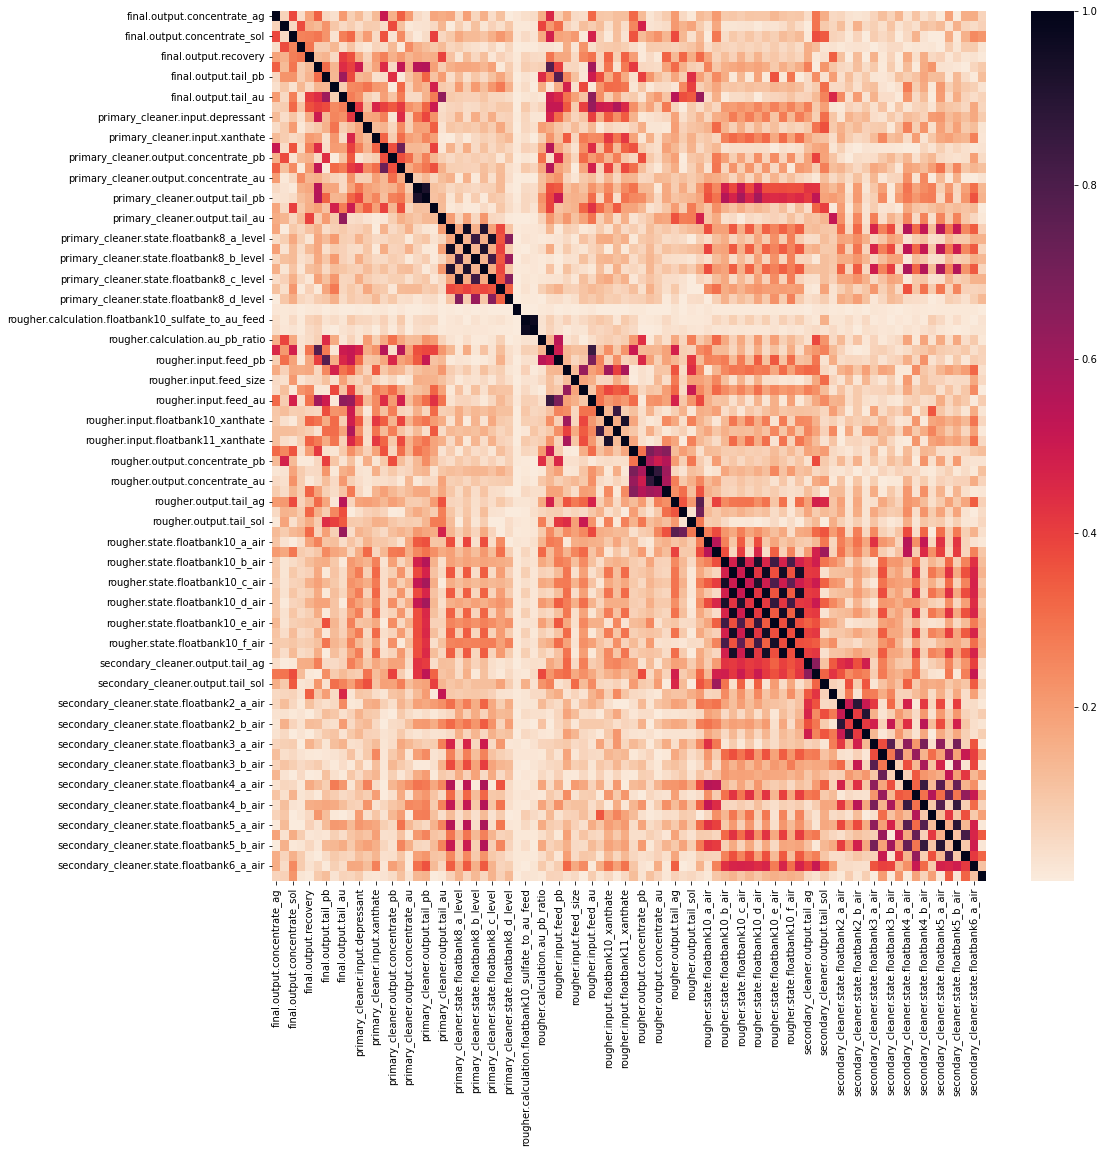

In [22]:
plt.figure(figsize = (16,16))
sns.heatmap(abs(df_full.corr()), cmap="rocket_r"); 

**Выводы:** Как в тренировочном так и в тестовом наборе встречаются высокоскореллированные признаки. Возможно по ним будет частичная мультиколинеарность которая будет мешать построению моделей (особенно линейных из за высокой погрешности оценки коэффициентов). Это повод либо провести отбор признаков либо применить модели с регуляризацией. 

### Проверка формула вычисления эффективности обогащения

Вычисляем её на обучающей выборке для признака rougher.output.recovery. Вычисляем MAE между расчётами и значением признака.

In [23]:
def calc_recovery(C, F, T):
    return C * (F - T) * 100 / (F * (C - T))

In [24]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
target_rec = df_train['rougher.output.recovery']
mean_absolute_error(target_rec, calc_recovery(C, F, T))

1.1131451184435918e-14

**Вывод:** MAE близка к 0, что говорит о праивильности формулы расчета. 

### Анализ признаков недоступных в тестовом наборе

In [25]:
only_train_cols = list(df_train.columns.difference(df_test.columns))
only_train_cols

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Выводы:** Во-первых в тестовом наборе нет признаков output, это целевые признаки, либо признаки напрямую с ними связанные. В тестовую выборку на следующих этапах придётся добавить только столбцы rougher.output.recovery, final.output.recovery. Во-вторых нет признаков обусловленнных тех. процессом: данные этих признаков рассчитываются позднее (на основании лабораторных анализов образцов) и недоступны во время процесса. Кроме того добавление этих признаков в фичи может спровоцировать цтечку целевого признака. Поэтому их необходимо удалить и из тренировочного набора.

### Предобработка данных


В тестовом наборе не хватает целевых признаков, но они там нужны. Поэтому из общей выборки выбираем строки и столбцы тестовой + таргет. Можно ориентироваться на дату так как пропусков по ней в тестовой выборки нет.

In [26]:
target_cols = ['rougher.output.recovery','final.output.recovery']
test_cols = list(df_test.columns)
test_cols_new = test_cols + target_cols
df_test_new = df_full[test_cols_new].copy()
df_test_new = df_test_new[df_test_new['date'].isin(df_test['date'])].reset_index(drop=True)
df_test_new.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


Проверяем равенство порядка первых столбцов.

In [27]:
(df_test.date != df_test_new.date).sum()

0

In [28]:
df_test = df_test_new

В тренировочном наборе отбрасываем все столбцы которых нет в тестовом.

In [29]:
df_train = df_train[test_cols_new]
df_train.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,70.541216
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,69.266198
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,68.116445
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,68.347543
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,66.927016


#### Целевые признаки 

В них удаляем пропуски по всем наборам

In [30]:
df_train = df_train.dropna(subset=['rougher.output.recovery','final.output.recovery'])
df_test = df_test.dropna(subset=['rougher.output.recovery','final.output.recovery'])
df_full = df_full.dropna(subset=['rougher.output.recovery','final.output.recovery'])

#### Фичи и прочие признаки

Фичи заполняем по ближайшему времени методом ffil

In [31]:
for df in (df_train, df_test, df_full):
    df.fillna(method='ffill', inplace=True)

In [32]:
for df in (df_train, df_test, df_full):
    print(df.isna().sum().sum())

0
0
0


Пропуски убраны.

## Анализ данных

### Изменение концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

<ipython-input-33-218fc24bfcc5>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_ax = sns.distplot(df_full.loc[:, cols], label=el, ax=ax)
<ipython-input-33-218fc24bfcc5>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_ax = sns.distplot(df_full.loc[:, cols], label=el, ax=ax)
<ipython-input-33-218fc24bfcc5>:17: 

<ipython-input-33-218fc24bfcc5>:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_ax = sns.distplot(df_full.loc[:, cols], label=el, ax=ax)
<ipython-input-33-218fc24bfcc5>:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_ax = sns.distplot(df_full.loc[:, cols], label=el, ax=ax)
<ipython-input-33-218fc24bfcc5>:27: 

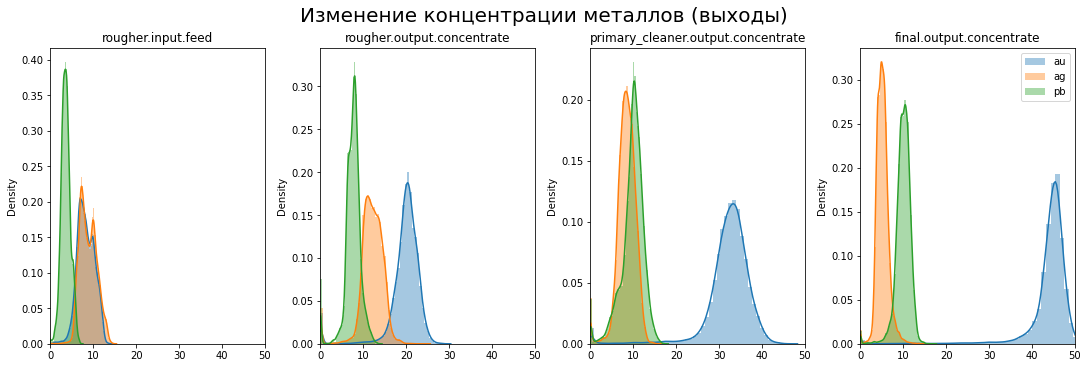

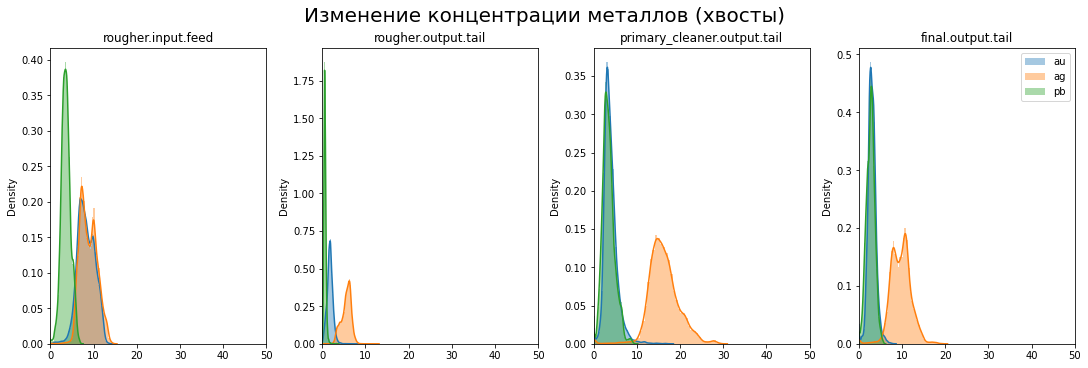

In [33]:
simplefilter(action='ignore', category=FutureWarning)
outs = ['rougher.input.feed', 'rougher.output.concentrate', 
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']
tails = ['rougher.input.feed', 'rougher.output.tail', 'primary_cleaner.output.tail',
         'final.output.tail']

elements = ['au', 'ag', 'pb']

fig, axs = plt.subplots(1, len(outs), figsize=(15, 5), constrained_layout=True)
fig.suptitle('Изменение концентрации металлов (выходы)', fontsize=20)
for stage, ax in zip(outs, axs):
    ax.set_title(stage)
    ax.set_xlim(0, 50)
    for el in elements:        
        cols = df_full.columns.str.contains(stage+'_'+el)
        sns_ax = sns.distplot(df_full.loc[:, cols], label=el, ax=ax)    
plt.legend()

fig, axs = plt.subplots(1, len(tails), figsize=(15, 5), constrained_layout=True)
fig.suptitle('Изменение концентрации металлов (хвосты)', fontsize=20)
for stage, ax in zip(tails, axs):
    ax.set_title(stage)
    ax.set_xlim(0, 50)
    for el in elements:        
        cols = df_full.columns.str.contains(stage+'_'+el)
        sns_ax = sns.distplot(df_full.loc[:, cols], label=el, ax=ax)   
plt.legend()

plt.show()

**Выводы:**
1) в выходе содержание золота сильно растёт на всех этапах. Немного увеличиватся среднее содержание свинца, в тоже время содержание серебра для этого технологического процесса немного снижается.

2) в хвостах содержание золота уменьшается после флотации, свинца в хвостах после флотации практически нет. После первого этапа очистки в хвостах растёт сильнее всего концентрация серебра. На второй стадии соотношение концентраций не меняется по сравнению с первой.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

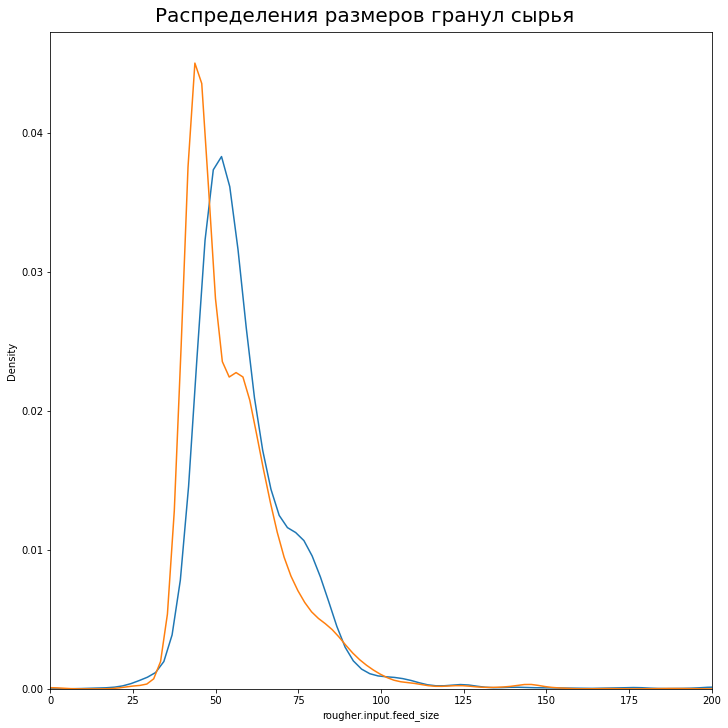

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True);
fig.suptitle('Распределения размеров гранул сырья', fontsize=20);
ax.set_xlim(0, 200)
sns.kdeplot(data=df_train['rougher.input.feed_size'], label='data_train', ax=ax);
sns.kdeplot(data=df_test['rougher.input.feed_size'], label='data_test', ax=ax);

**Вывод:** Визуально распределения похожи и размеры гранул в двух выборках отличаются не сильно.

### Измение суммарной концентрации всех веществ на разных стадиях тех. процесса.

In [35]:
c_first_series = df_full.loc[:, ['rougher.input.feed_au',
                                'rougher.input.feed_ag',
                                'rougher.input.feed_pb',
                                'rougher.input.feed_sol']].sum(axis=1)
c_r_series = df_full.loc[:, ['rougher.output.concentrate_au',
                                'rougher.output.concentrate_ag',
                                'rougher.output.concentrate_pb',
                                'rougher.output.concentrate_sol']].sum(axis=1)
c_p_series = df_full.loc[:, ['primary_cleaner.output.concentrate_ag',
                         'primary_cleaner.output.concentrate_au',
                         'primary_cleaner.output.concentrate_pb',
                         'primary_cleaner.output.concentrate_sol']].sum(axis=1)

c_f_series = df_full.loc[:, ['final.output.concentrate_au',
                               'final.output.concentrate_ag',
                               'final.output.concentrate_pb',
                               'final.output.concentrate_sol']].sum(axis=1)
dfc = pd.DataFrame({'Сырьё':c_first_series,
                    'Флотация':c_r_series,
                    'Предварительная очистка':c_p_series, 
                    'Продукт':c_f_series})
dfc.head()

,Сырьё,Флотация,Предварительная очистка,Продукт
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667


#### Статистика

In [36]:
dfc.describe()

,Сырьё,Флотация,Предварительная очистка,Продукт
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,57.320789,68.170865,60.764731,68.653624
std,7.212680,12.491279,10.017271,7.427536
min,0.040000,0.000000,0.000000,0.000000
25%,53.557679,66.012495,58.929364,67.932362
50%,57.594391,70.181495,62.497674,69.598444
75%,61.953459,74.356904,65.667336,71.368472
max,76.978947,88.140119,80.749343,80.210644


#### График функции плотности вероятности

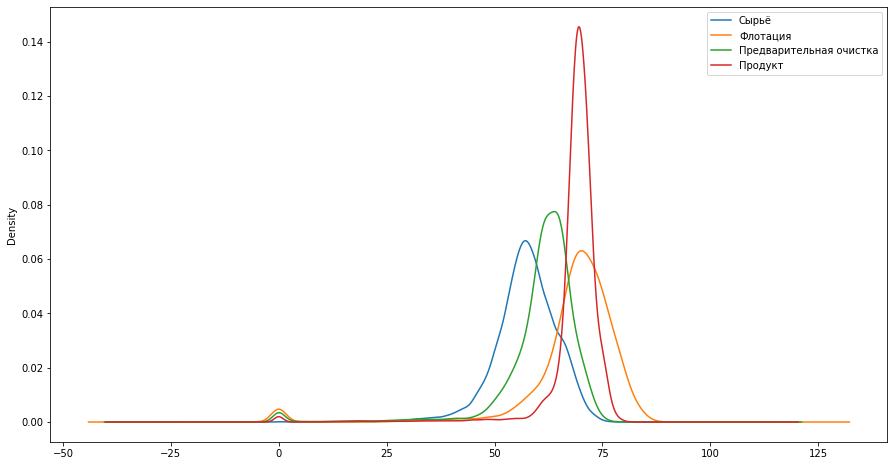

In [37]:
dfc.plot.kde(figsize=(15, 8));

Уберём пик около нуля - это следствие погрешности измерения.

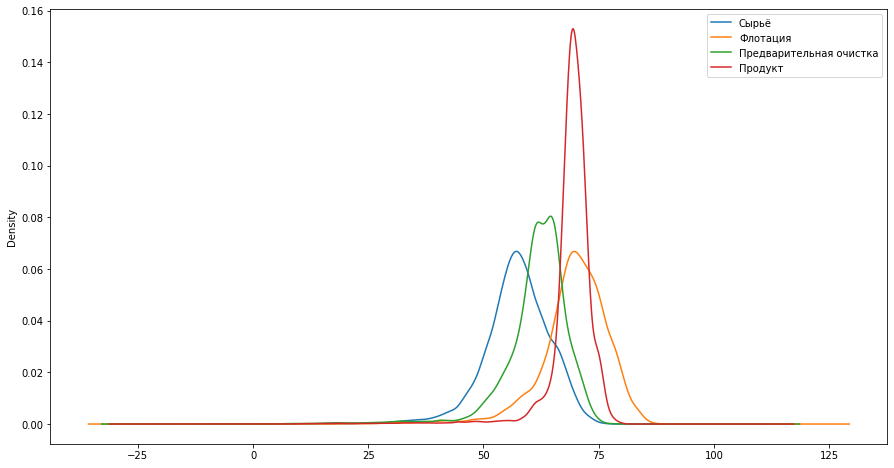

In [38]:
dfc[dfc>5].plot.kde(figsize=(15, 8));

**Выводы:** На стадии флотации суммарная концентрация возрастает. На предварительной очистке падает, потом опять возрастает.

## Модель

### Подготовка данных

In [39]:
SEED = 12345
features_cols = test_cols[1:]
target_train = df_train[target_cols]
features_train = df_train[features_cols]
target_train, features_train = shuffle(target_train, features_train, random_state=SEED)
scaler = StandardScaler()
features_train = pd.DataFrame(scaler.fit_transform(features_train), columns=features_train.columns)

### Функции sMAPE и итоговый sMAPE

In [40]:
def smape(y, y_pred):
    return (((abs(y - y_pred) * 2 * 100) /
              (abs(y) + abs(y_pred))).sum()) / len(y)

def total_smape(rougher_smape, final_smape):
    return 0.25 * rougher_smape + 0.75 * final_smape

### Обучение и проверка моделей

#### Обучение и выбор моделей

Напишем общий класс кастомного оценщика.

In [41]:
class MyBaseRegressor(BaseEstimator):
    
    def __init__(self):
        self.model1 = None
        self.model2 = None
    
    def fit(self, x, y):
        data_cols = pd.Series(x.columns)
        rougher_cols = list(data_cols[data_cols.str.contains('rougher.input|rougher.state')])
        final_cols = list(data_cols[~data_cols.str.contains('rougher.input|rougher.state')])
        x1 = x[rougher_cols]
        x2 = x[final_cols]
        y1 = y['rougher.output.recovery']
        y2 = y['final.output.recovery']
        self.model1.fit(x1, y1)
        self.model2.fit(x2, y2)
    
    def score(self, x, y):
        data_cols = pd.Series(x.columns)
        rougher_cols = list(data_cols[data_cols.str.contains('rougher.input|rougher.state')])
        final_cols = list(data_cols[~data_cols.str.contains('rougher.input|rougher.state')])
        x1 = x[rougher_cols]
        x2 = x[final_cols]
        y1 = y['rougher.output.recovery']
        y2 = y['final.output.recovery']
        y1_pred = self.model1.predict(x1)
        y2_pred = self.model2.predict(x2)
        rougher_smape = smape(y1, y1_pred)
        final_smape = smape(y2, y2_pred)
        return total_smape(rougher_smape, final_smape)
        

#### Базовая линия

In [42]:
class MyDummyRegressor(MyBaseRegressor):
    def __init__(self):
        self.model1 = DummyRegressor()
        self.model2 = DummyRegressor()
model_dummy = MyDummyRegressor()
dummy_score = cross_val_score(model_dummy, features_train, target_train).mean()
dummy_score

11.293533105762272

#### Линейная регрессия

In [43]:
class MyLinearRegressor(MyBaseRegressor):
    def __init__(self):
        self.model1 = LinearRegression()
        self.model2 = LinearRegression()
model_linear = MyLinearRegressor()
linear_score = cross_val_score(model_linear, features_train, target_train).mean()
linear_score

9.71066189611425

Неплохо по сравнению с базовой линеей. Но что дадут линейные модели с регулярицией (для борьбы с мульимколинеарностью) и деревья.

#### Гребневая регрессия

Будем подбирать параметр регуляризации по сетке, используя GridSearchCV, отдельно для каждой модели сборной модели. Но есть один ньюанс: скоринг у нас минизируется, а не максимизируется поэтому параметры лучшей модели и лучший скоринг придется доставать вручную.

In [44]:
class MyRidgeRegressor(MyBaseRegressor):
    rougher_alpha = 1.0
    final_alpha = 1.0
    
    def __init__(self, rougher_alpha=1.0, final_alpha=1.0):
        self.rougher_alpha = rougher_alpha
        self.final_alpha = final_alpha

    def fit(self,x, y):
        self.model1 = Ridge(self.rougher_alpha, random_state=SEED)
        self.model2 = Ridge(self.final_alpha, random_state=SEED)
        super().fit(x, y)

params = {'rougher_alpha': np.logspace(-2, 3, 6), 'final_alpha': np.logspace(-2, 3, 6)}
rr = MyRidgeRegressor()
model_ridge = GridSearchCV(rr, params, n_jobs=-1)
model_ridge.fit(features_train, target_train)
ridge_score = model_ridge.cv_results_['mean_test_score'].min()
ridge_score

9.665470590596914

In [45]:
ridge_par = model_ridge.cv_results_['params'][model_ridge.cv_results_['mean_test_score'].argmin()]
ridge_par

{'final_alpha': 1000.0, 'rougher_alpha': 1000.0}

L2 регуляризация помогает. Попробуем L1.
#### Лассо

In [46]:
class MyLassoRegressor(MyBaseRegressor):
    rougher_alpha = 1.0
    final_alpha = 1.0
    
    def __init__(self, rougher_alpha=1.0, final_alpha=1.0):
        self.rougher_alpha = rougher_alpha
        self.final_alpha = final_alpha

    def fit(self,x, y):
        self.model1 = Lasso(self.rougher_alpha, random_state=SEED)
        self.model2 = Lasso(self.final_alpha, random_state=SEED)
        super().fit(x, y)

params = {'rougher_alpha': np.logspace(-3, 2, 6), 'final_alpha': np.logspace(-3, 2, 6)}
lr = MyLassoRegressor()
model_lasso = GridSearchCV(lr, params, n_jobs=-1)
model_lasso.fit(features_train, target_train)
lasso_score = model_lasso.cv_results_['mean_test_score'].min()
lasso_score

9.693718638028042

In [47]:
lasso_par = model_lasso.cv_results_['params'][model_lasso.cv_results_['mean_test_score'].argmin()]
lasso_par

{'final_alpha': 0.1, 'rougher_alpha': 0.1}

Результат немного хуже, чем у гребневой.

#### Дерево решений
Здесь придётся отказаться от раздельного перебора параметров для моделей иначе обучение затянется.

In [48]:
class MyTreeRegressor(MyBaseRegressor):
    d_tree = 1
    
    def __init__(self, d_tree=1):
        self.d_tree = d_tree

    def fit(self,x, y):
        self.model1 = DecisionTreeRegressor(max_depth=self.d_tree, random_state=SEED)
        self.model2 = DecisionTreeRegressor(max_depth=self.d_tree, random_state=SEED)
        super().fit(x, y)

params = {'d_tree': list(range(4, 15))}
dt = MyTreeRegressor()
model_dt = GridSearchCV(dt, params, n_jobs=-1)
model_dt.fit(features_train, target_train)
dt_score = model_dt.cv_results_['mean_test_score'].min()
dt_score

8.742487269975035

In [49]:
dt_par = model_dt.cv_results_['params'][model_dt.cv_results_['mean_test_score'].argmin()]
dt_par

{'d_tree': 11}

Лучше, чем линейные модели.

#### Случайный лес

In [50]:
class MyRandomForestRegressor(MyBaseRegressor):
    n_trees = 50
    d_trees = 5
    
    def __init__(self, n_trees=50, d_trees=5):
        self.n_trees = n_trees
        self.d_trees = d_trees

    def fit(self,x, y):
        self.model1 = RandomForestRegressor(max_depth=self.d_trees, n_estimators=self.n_trees, random_state=SEED)
        self.model2 = RandomForestRegressor(max_depth=self.d_trees, n_estimators=self.n_trees, random_state=SEED)
        super().fit(x, y)

params = {'d_trees': list(range(10, 15)), 'n_trees': [50, 100, 250]}
rf = MyRandomForestRegressor()
model_rf = GridSearchCV(rf, params, n_jobs=-1)
model_rf.fit(features_train, target_train)
rf_score = model_rf.cv_results_['mean_test_score'].min()
rf_score

7.601026131059962

In [51]:
model_rf.cv_results_['mean_test_score']

array([8.08054682, 8.06547023, 8.05409491, 7.95607419, 7.92726025,
       7.91254262, 7.83950771, 7.80419069, 7.78582666, 7.74385104,
       7.70081124, 7.68242476, 7.66324062, 7.62323316, 7.60102613])

In [52]:
rf_par = model_rf.cv_results_['params'][model_rf.cv_results_['mean_test_score'].argmin()]
rf_par

{'d_trees': 14, 'n_trees': 250}

Хм. Модель действительно самая лучшая на обучающей выборки, но есть одно но - деревья регрессии не могут экстаполировать. только интерполировать, в отличие от линейных моделей - это может сказаться на оценке по тестовым данным. К тому же время обучения и подбора гиперпараметров очень большое.

#### Общий результат

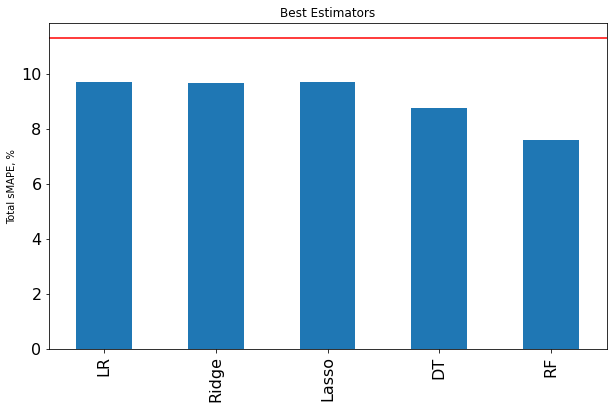

In [53]:
fig = pd.Series(data=[linear_score,
                      ridge_score,
                      lasso_score,
                      dt_score,
                      rf_score],
                index=['LR', 'Ridge',
                       'Lasso', 'DT', 'RF']).plot(kind='bar', 
                      title="Best Estimators",
                      fontsize=16,
                      figsize=(10,6))
fig.set_ylabel('Total sMAPE, %');
plt.axhline(y = dummy_score, color = 'r', linestyle = '-');

**Выводы:** Все исследованные модели показывают адекватность. Лучше всего справляется с тренировочным набором модель случайного леса. Линейные модели хуже.

### Проверка модели на тестовом наборе

#### Базовая линия

In [54]:
target_test = df_test[target_cols]
features_test = df_test[test_cols[1:]]
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)
dummy = MyDummyRegressor()
dummy.fit(features_train, target_train)
dummy.score(features_test, target_test)

10.289630376021034

#### Лучшая модель

In [55]:
best_model = MyRandomForestRegressor(n_trees=250, d_trees=14)
best_model.fit(features_train, target_train)
best_model.score(features_test, target_test)

12.380047200024432

In [56]:
best_model_2 = MyRidgeRegressor(rougher_alpha=1000, final_alpha=1000)
best_model_2.fit(features_train, target_train)
best_model_2.score(features_test, target_test)

9.58158382039967

**Выводы:** Лучшая модель провалила испытания, а вот гребневая регрессия сработала как и на тренеровочном.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке